In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from layers import Flatten,FullyConnected,Linear,Tanh
from losses import cross_entropy, cross_entropy_prime
from network import train, predict
from scipy import signal


# 08

In [2]:
class ConvolutionalNet():
    
    def __init__(self, input_shape, kernel, channel_count):
        """
        :param input_shape: input shape: (channel_count, height, width)
        :param kernel: kernel shape: (channel_count, input_channel_count, height, width)
        :param channel_count: number of output channels
        :return None
    
        """
        input_channel_count, input_height, input_width = input_shape
        self.channel_count = channel_count
        self.input_shape = input_shape
        self.input_channel_count = input_channel_count
        self.output_shape = (channel_count, input_height - kernel + 1, input_width - kernel + 1)
        self.kernels_shape = (channel_count, input_channel_count, kernel, kernel)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward_pass(self, input):
        """
        :param input: input shape: (channel_count, height, width)
        :return: output shape: (channel_count, height - kernel + 1, width - kernel + 1)

        """
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.channel_count):
            for j in range(self.input_channel_count):
                self.output[i] += signal.correlate2d(
                    self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        """
        :param output_gradient: output gradient shape: (channel_count, height - kernel + 1, width - kernel + 1)
        :return: input gradient shape: (channel_count, height, width)

        """
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.channel_count):
            for j in range(self.input_channel_count):
                kernels_gradient[i, j] = signal.correlate2d(
                    self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(
                    output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

# 09

## preprocess the data

In [3]:
def preprocess_data(x, y, limit):
    """
    :param x: input data
    :param y: output data
    :param limit: number of samples to be used
    :return: x and y data with shape (limit, 28, 28) and (limit, 10) respectively
    
    """
    x = x[:limit]
    y = y[:limit]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype("float32") / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 10, 1)
    return x, y


## Load the Data

In [4]:
data = mnist.load_data()

In [5]:
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 1000)
x_test, y_test = preprocess_data(x_test, y_test, 200)

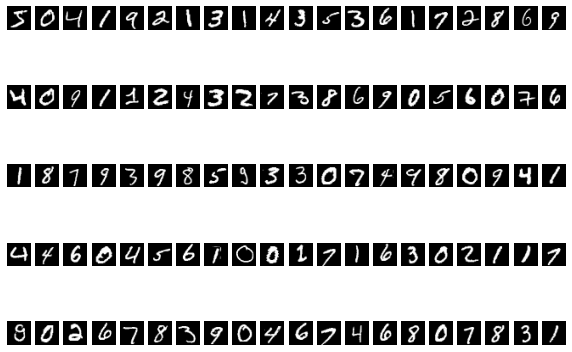

In [6]:
#show first 20 images present in x_train


fig = plt.figure(figsize=(10, 7))

for i in range(100):
    fig.add_subplot(5, 20, i+1)
    plt.imshow(data[0][0][i], 'gray')
    plt.axis('off')

plt.show()
    

In [7]:
#print the size of the training and test data
print(x_train.shape)
print(y_train.shape)

(1000, 1, 28, 28)
(1000, 10, 1)


## Train the Network

In [8]:

# Train this CNN on mnist dataset. Layer 1: Convolution layer with 16 out-
# put channels+flatten+tanh activation. Layer 2: 10 output neuron with linear
# activation. Softmax cross entropy loss

CNN = [
    ConvolutionalNet((1, 28, 28), 3, 16),
    Tanh(),
    Flatten((16, 26, 26), (16 * 26 * 26, 1)),
    FullyConnected(16* 26 * 26, 100),
    Linear(),
    FullyConnected(100, 10),
    Linear()
]

In [9]:
# train
train(
    CNN,
    cross_entropy,
    cross_entropy_prime,
    x_train,
    y_train,
    epochs=10,
    learning_rate=0.1
)

1/10, ----- error for this epoch is=0.43202484960349363
2/10, ----- error for this epoch is=0.3006852607616528
3/10, ----- error for this epoch is=0.2697651444444747


KeyboardInterrupt: 

## Test the Data

In [ ]:
# test
test=[]
pred=[]
for x, y in zip(x_test, y_test):
    output = predict(CNN, x)
    test.append(np.argmax(output))
    pred.append(np.argmax(y))
#find the accuracy
print('accuracy:',np.sum(np.array(test)==np.array(pred))*100/len(test))

accuracy: 58.5
